In [1]:
# !pip install statsmodels tensorflow

In [2]:
!pip install prophet neuralprophet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 67.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.

In [35]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score,root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler


from keras import backend as k #to make the keras job faster
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,GRU, SimpleRNN, Bidirectional,LeakyReLU,ReLU,Conv1D,MaxPooling1D,Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from prophet import Prophet
from neuralprophet import NeuralProphet


from joblib import Parallel, delayed #for faster and parallel computation


In [36]:
import importlib

libraries = [
    "os", "kagglehub", "pandas", "numpy", "matplotlib", "seaborn", "warnings",
    "statsmodels", "sklearn", "keras", "prophet", "neuralprophet", "joblib"
]

for lib in libraries:
    try:
        module = importlib.import_module(lib)
        version = getattr(module, "__version__", "Version info not available")
        print(f"{lib}: {version}")
    except ImportError:
        print(f"{lib}: Not installed")


os: Version info not available
kagglehub: 0.3.13
pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
seaborn: 0.13.2
warnings: Version info not available
statsmodels: 0.14.5
sklearn: 1.6.1
keras: 3.10.0
prophet: 1.1.7
neuralprophet: 0.8.0
joblib: 1.5.2


In [4]:


# Download latest version (will be downloaded to /kaggle/input/...)
dataset_path = kagglehub.dataset_download("paulbrabban/daily-minimum-temperatures-in-melbourne")

# Define the desired destination path
destination_path = "/content/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the contents of the downloaded dataset to the destination path
# We use shell command for simplicity, you could also use shutil.copytree
!cp -r "{dataset_path}/." "{destination_path}/"

print(f"Dataset copied to: {destination_path}")

# List files in the destination directory to confirm
!ls "{destination_path}"

Using Colab cache for faster access to the 'daily-minimum-temperatures-in-melbourne' dataset.
Dataset copied to: /content/
daily-minimum-temperatures-in-me.csv  sample_data


In [5]:
## Checking the bad records, when reading by pandas thorwing error for bad records at row no 3653

with open("/content/daily-minimum-temperatures-in-me.csv") as f:
    for i, line in enumerate(f, start=1):
        if i == 3653:
            print(line)
            break




Daily minimum temperatures in Melbourne, Australia, 1981-1990



In [6]:
data = pd.read_csv("/content/daily-minimum-temperatures-in-me.csv", parse_dates=['Date'], index_col='Date', delimiter=',', skipfooter=1,on_bad_lines="skip")
data.head(5)

Daily minimum temperatures in Melbourne, Australia, 1981-1990
Date                                                                    
1981-01-01                                               20.7           
1981-01-02                                               17.9           
1981-01-03                                               18.8           
1981-01-04                                               14.6           
1981-01-05                                               15.8

In [7]:
#checking for null values
data.isnull().sum()

Daily minimum temperatures in Melbourne, Australia, 1981-1990    0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   Daily minimum temperatures in Melbourne, Australia, 1981-1990  3650 non-null   object
dtypes: object(1)
memory usage: 57.0+ KB


In [9]:
# Change the datatype from object to number
data['Daily minimum temperatures in Melbourne, Australia, 1981-1990'] = pd.to_numeric(data['Daily minimum temperatures in Melbourne, Australia, 1981-1990'], errors='coerce')

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Daily minimum temperatures in Melbourne, Australia, 1981-1990  3647 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [11]:
data.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3650, freq=None)

In [12]:
data.describe()

Daily minimum temperatures in Melbourne, Australia, 1981-1990
count                                        3647.000000            
mean                                           11.186647            
std                                             4.061671            
min                                             0.000000            
25%                                             8.300000            
50%                                            11.000000            
75%                                            14.000000            
max                                            26.300000

Till above reading file using pandas and skipping bad records.

the index is set as date and temperature for Melbourne, Australia, 1981-1990 is column.


In [13]:
data.rename(columns={"Daily minimum temperatures in Melbourne, Australia, 1981-1990":"Temperature"}, inplace=True)
data.head(5)

Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8

In [14]:
print(data.index.min(), data.index.max())

1981-01-01 00:00:00 1990-12-31 00:00:00


In [15]:
print(pd.infer_freq(data.index))

# This will return 'D', 'M', 'MS', etc. if the data is regular. If it returns None, the index is irregular.

None


**Identify Missing Dates**

In [16]:
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
missing = date_range.difference(data.index)
print("Missing Dates:", missing)

Missing Dates: DatetimeIndex(['1984-12-31', '1988-12-31'], dtype='datetime64[ns]', freq=None)


Missing dates are '1984-12-31', '1988-12-31'

In [17]:
# Filling the missing records, here first creating the index for missing dates
data = data.reindex(date_range)

In [18]:
# Reconfirming the missing dates are filled or not

date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
missing = date_range.difference(data.index)
print("Missing Dates:", missing)

Missing Dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [19]:
print(data.loc['1984-12-30':'1985-01-02'])
print(data.loc['1988-12-30':'1989-01-02'])


            Temperature
1984-12-30         16.4
1984-12-31          NaN
1985-01-01         13.3
1985-01-02         15.2
            Temperature
1988-12-30         14.1
1988-12-31          NaN
1989-01-01         14.3
1989-01-02         17.4


In [20]:
# Filling the missing value using interpolation

data['Temperature'].interpolate(method='time',inplace=True)

In [21]:
print(data.loc['1984-12-30':'1985-01-02'])
print(data.loc['1988-12-30':'1989-01-02'])


            Temperature
1984-12-30        16.40
1984-12-31        14.85
1985-01-01        13.30
1985-01-02        15.20
            Temperature
1988-12-30         14.1
1988-12-31         14.2
1989-01-01         14.3
1989-01-02         17.4


In [22]:
data

Temperature
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8
...                 ...
1990-12-27         14.0
1990-12-28         13.6
1990-12-29         13.5
1990-12-30         15.7
1990-12-31         13.0

[3652 rows x 1 columns]

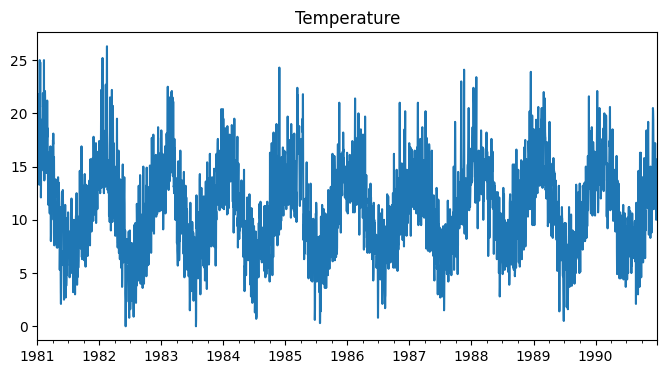

In [23]:
data['Temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.show()

<Axes: >

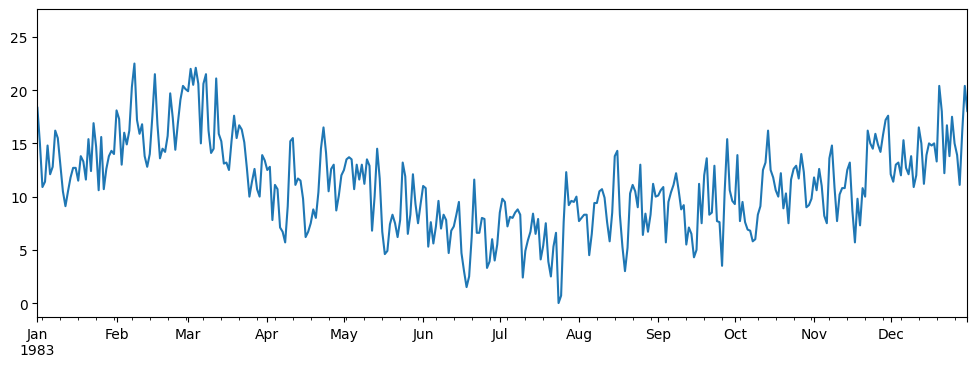

In [24]:
data['Temperature'].plot(xlim=['1983-01-01','1983-12-31'],figsize=(12,4))

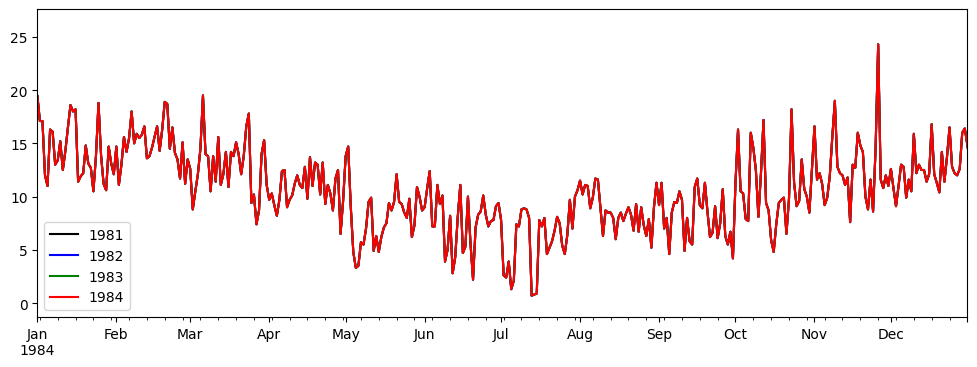

In [25]:
data['Temperature'].plot(xlim=['1981-01-01','1981-12-31'],figsize=(12,4),color='black',label='1981')
data['Temperature'].plot(xlim=['1982-01-01','1982-12-31'],figsize=(12,4),color='blue',label='1982')
data['Temperature'].plot(xlim=['1983-01-01','1983-12-31'],figsize=(12,4),color='green',label='1983')
data['Temperature'].plot(xlim=['1984-01-01','1984-12-31'],figsize=(12,4),color='red',label='1984')
plt.legend()
plt.show()



It shows same trend to all the years, in which temperature is downward trend from May to July and again getting in same throuhout months trend.

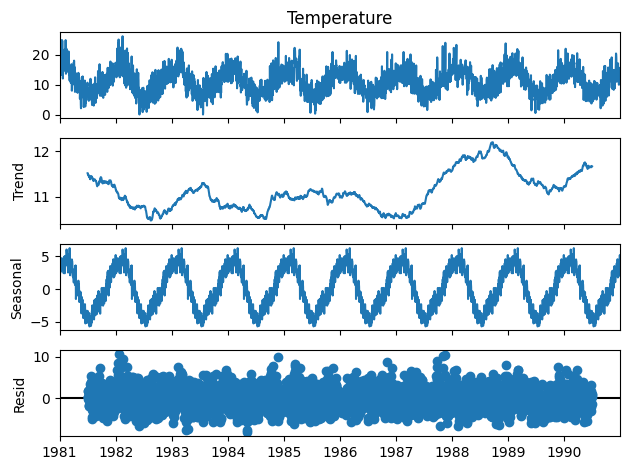

In [26]:

result = seasonal_decompose(data['Temperature'], model='additive', period=365)
result.plot()
plt.show()


The chart has **four subplots**:

---

### **1️⃣ Observed (Top plot)**

* This is the **raw data**: daily temperatures.
* Shows all components together: trend + seasonal + residual.
* we can see clear **yearly seasonality** (summer vs winter) and **short-term fluctuations** (daily variation).

---

### **2️⃣ Trend (Second plot)**

* The **long-term direction** of the series.
* Smoothed line over time (usually with moving average or LOESS).
* Shows **gradual increase or decrease** over years.
* In the chart:

  * From 1981–1987, slight downward trend.
  * Around 1987–1990, slight upward trend.
* Captures **slow changes in average temperature**.

---

### **3️⃣ Seasonal (Third plot)**

* The **repeating pattern within each year**.
* Seasonal component is **periodic**, in this case yearly (`period=365`).
* Shows **winter lows and summer highs** recurring each year.
* The amplitude is consistent (additive model assumes constant amplitude).

---

### **4️⃣ Residual / Remainder (Bottom plot)**

* The **noise** or **unexplained variation** after removing trend and seasonality.
* Ideally looks **random around 0**.
* In chart:

  * Most points hover around 0.
  * Occasional spikes → unusual temperature events or measurement noise.

---

### ✅ How to interpret this decomposition:

1. **Trend** → underlying long-term increase/decrease.
2. **Seasonal** → repeated patterns (summer/winter cycles).
3. **Residual** → random fluctuations, errors, or outliers.
4. **Observed** → combination of all three.

---

💡 **Why use decomposition?**

* Helps **understand the structure** of your series.
* **Preprocessing**: remove trend/seasonality before modeling residuals.
* **Forecasting**: you can forecast trend and seasonality separately, then combine.


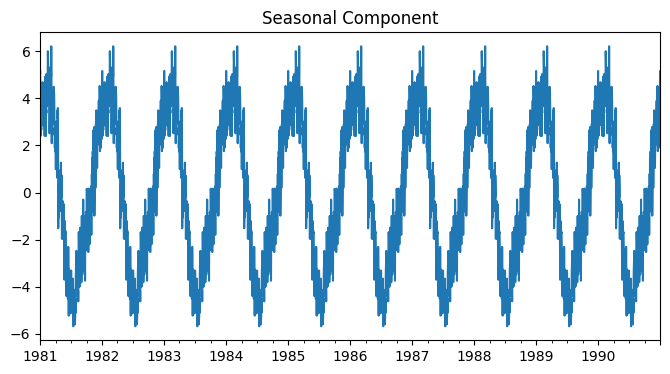

In [27]:
result.seasonal.plot(figsize=(8, 4), title='Seasonal Component')
plt.show()

In [28]:
data['Temperature'].max()

26.3

In [29]:
data.resample(rule='A').min()

Temperature
1981-12-31          2.1
1982-12-31          0.0
1983-12-31          0.0
1984-12-31          0.7
1985-12-31          0.3
1986-12-31          0.8
1987-12-31          1.5
1988-12-31          2.8
1989-12-31          0.5
1990-12-31          2.1

In [32]:
data.resample(rule='A').max()

Temperature
1981-12-31         25.0
1982-12-31         26.3
1983-12-31         22.5
1984-12-31         24.3
1985-12-31         22.4
1986-12-31         21.4
1987-12-31         24.1
1988-12-31         23.9
1989-12-31         22.0
1990-12-31         22.1

**Test for Stationarity**

Use Augmented Dickey-Fuller test (ADF test):



*   p-value < 0.05 → reject null hypothesis → data is stationary
*   p-value > 0.05 → not stationary → apply transformations



In [17]:

result = adfuller(data['Temperature'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -4.436765044195098
p-value: 0.0002553838746235325


Above results means the data is stationary(i.e mean, variance do not change over time)

for ARIMA or SARIMA the value for I (i.e differencing could be 0)

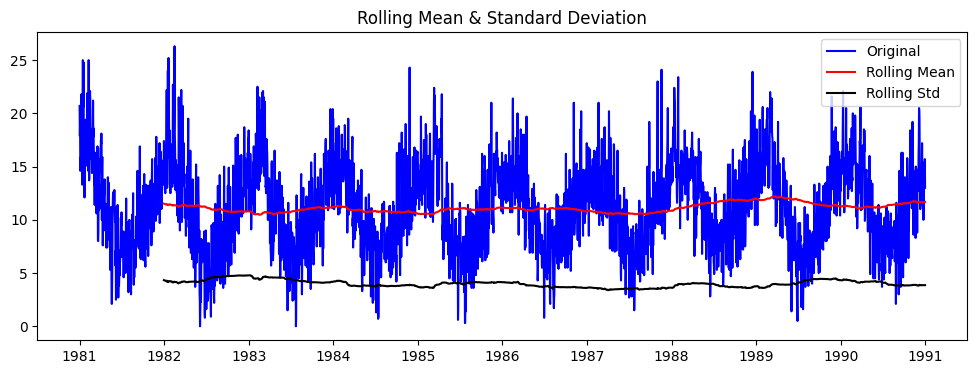

In [34]:
rolmean = data['Temperature'].rolling(window=365).mean()
rolstd = data['Temperature'].rolling(window=365).std()

plt.figure(figsize=(12,4))
plt.plot(data['Temperature'], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
# data['Temperature'].plot(figsize=(12,4), title='Original Series')

plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()


**Above graph shows both red and balck line in straight( not showing any upward or downwrad trend) which means data is stationary.**

Above results means the data is stationary(i.e mean, variance do not change over time)

for ARIMA or SARIMA the value for I (i.e differencing could be 0)

**Checking for ACF and PACF with lag 7,14,30 and 60 lags, as we have daily data to check for weekly, 2weekly , monthly and 2monthly**

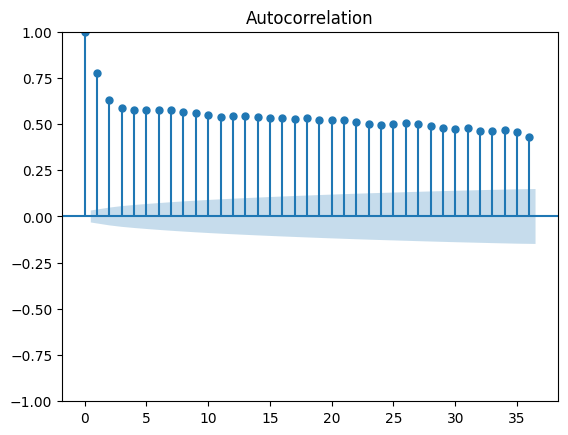

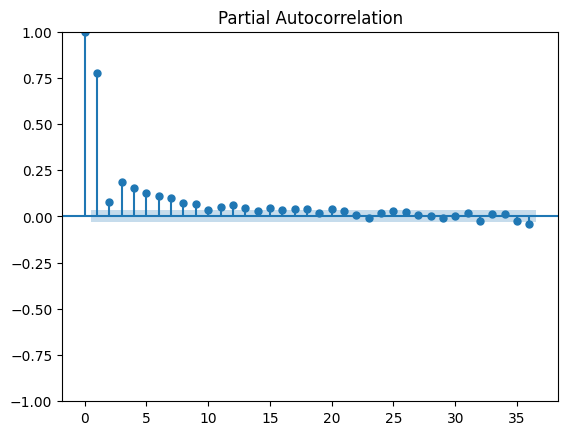

In [35]:
plot_acf(data['Temperature'].dropna())
plot_pacf(data['Temperature'].dropna())
plt.show()


In ACF, we can see the positive correlation, means the previous day temperature has impact for next day temperature.

lag2 is showing spike so,may be we can try with AR(2)

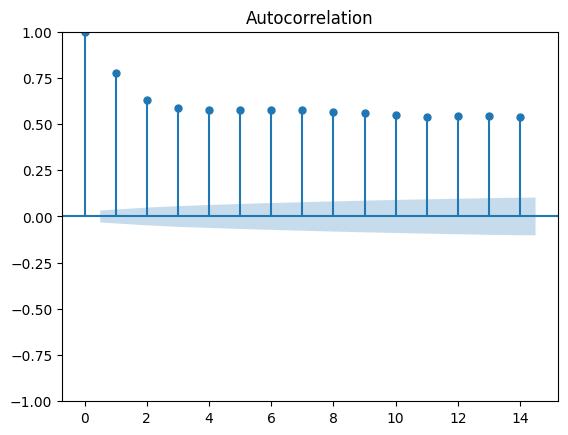

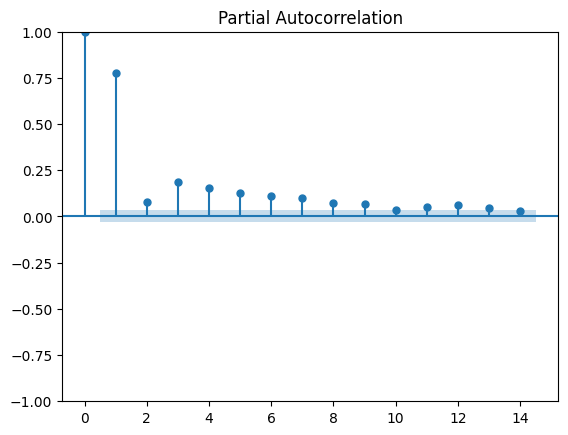

In [36]:
plot_acf(data['Temperature'].dropna(), lags=14)
plot_pacf(data['Temperature'].dropna(), lags=14)
plt.show()


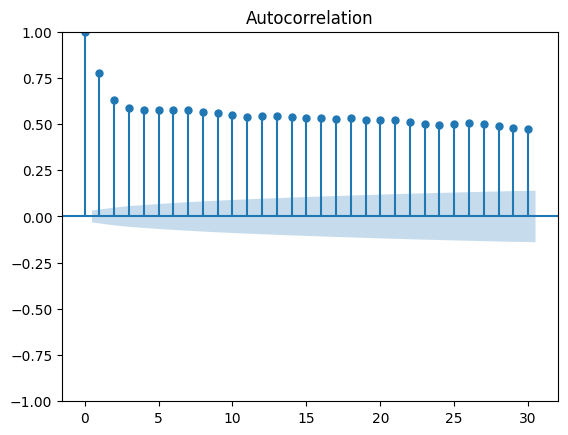

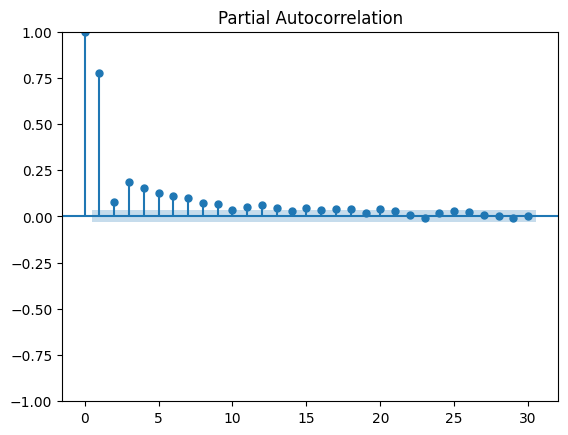

In [37]:
plot_acf(data['Temperature'].dropna(), lags=30)
plot_pacf(data['Temperature'].dropna(), lags=30)
plt.show()


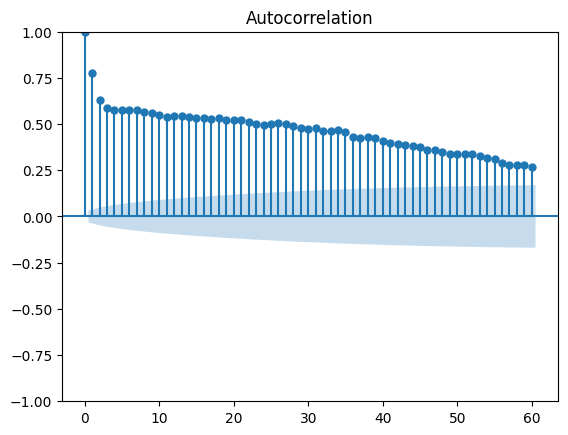

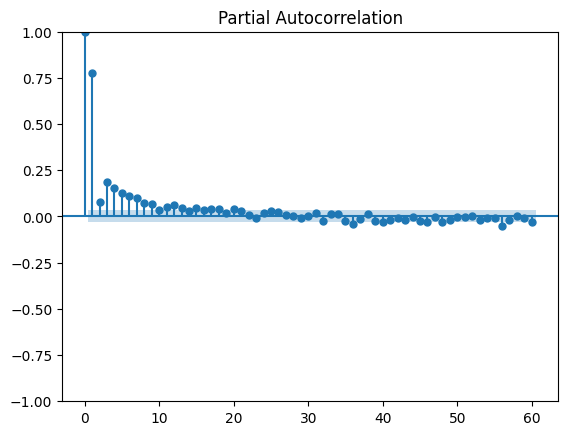

In [38]:
plot_acf(data['Temperature'].dropna(), lags=60)
plot_pacf(data['Temperature'].dropna(), lags=60)
plt.show()


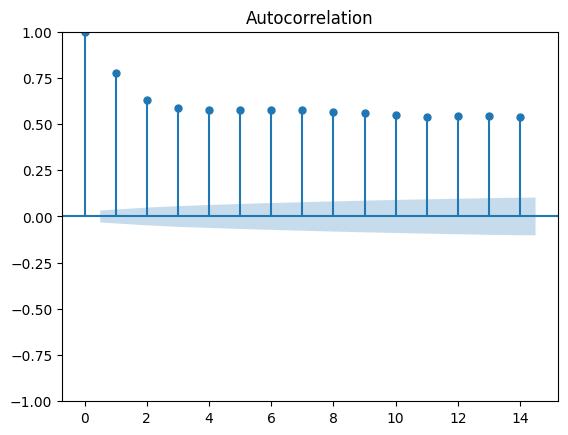

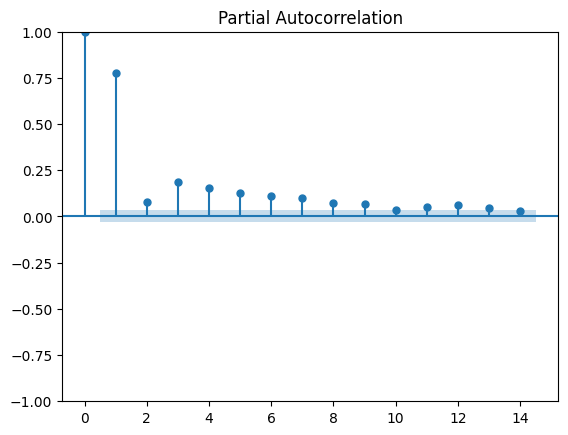

In [39]:
plot_acf(data['Temperature'].dropna(), lags=14)
plot_pacf(data['Temperature'].dropna(), lags=14)
plt.show()


In [18]:
# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size], data[train_size:]

print('Training dataset shape:', train_data.shape)
print('Testing dataset shape:', test_data.shape)

Training dataset shape: (2921, 1)
Testing dataset shape: (731, 1)


In [41]:
test_data

Temperature
1988-12-31         14.2
1989-01-01         14.3
1989-01-02         17.4
1989-01-03         18.5
1989-01-04         16.8
...                 ...
1990-12-27         14.0
1990-12-28         13.6
1990-12-29         13.5
1990-12-30         15.7
1990-12-31         13.0

[731 rows x 1 columns]

In [49]:

results = []

# Loop through p, d, q
for p in range(0, 5):
    for d in range(0, 3):
        for q in range(0, 5):
            try:
                # Fit model on training data
                model = ARIMA(train_data, order=(p, d, q))
                model_fit = model.fit()


                # Training evaluation

                train_pred = model_fit.predict(start=0, end=len(train_data)-1)
                train_rmse = np.sqrt(mean_squared_error(train_data, train_pred))
                train_r2 = r2_score(train_data, train_pred)


                # Testing evaluation (forecast)

                test_pred = model_fit.forecast(steps=len(test_data))
                test_rmse = np.sqrt(mean_squared_error(test_data, test_pred))
                test_r2 = r2_score(test_data, test_pred)


                results.append({
                    'p': p, 'd': d, 'q': q,
                    'AIC': model_fit.aic,
                    'BIC': model_fit.bic,
                    'Train_RMSE': train_rmse,
                    'Train_R2': train_r2,
                    'Test_RMSE': test_rmse,
                    'Test_R2': test_r2
                })

            except:
                continue  # skip invalid combos

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by Test_RMSE
results_df = results_df.sort_values(by="Test_RMSE").reset_index(drop=True)

# Show top 10 models
print(results_df.head(10))


   p  d  q           AIC           BIC  Train_RMSE  Train_R2  Test_RMSE  \
0  1  0  2  13565.432094  13595.330500    2.466346  0.630101   3.985568   
1  3  0  3  13542.024400  13589.861850    2.453962  0.633807   4.010563   
2  4  0  2  13541.743554  13589.581004    2.453887  0.633829   4.016041   
3  3  0  1  13537.870465  13573.748553    2.453945  0.633812   4.016683   
4  4  0  3  13543.702360  13597.519492    2.453866  0.633835   4.016846   
5  4  0  1  13539.865807  13581.723576    2.453943  0.633813   4.017108   
6  4  0  4  13546.502457  13606.299270    2.454171  0.633744   4.020450   
7  3  0  4  13544.118080  13597.935211    2.454047  0.633782   4.020572   
8  1  0  3  13538.733352  13574.611440    2.454304  0.633705   4.020665   
9  2  0  3  13540.645989  13582.503758    2.454272  0.633714   4.021310   

    Test_R2  
0  0.056071  
1  0.044194  
2  0.041582  
3  0.041275  
4  0.041197  
5  0.041072  
6  0.039476  
7  0.039418  
8  0.039373  
9  0.039065  


In [51]:
best_by_rmse = results_df.loc[results_df['Train_RMSE'].idxmin()]
best_by_r2 = results_df.loc[results_df['Train_R2'].idxmax()]
best_by_aic = results_df.loc[results_df['AIC'].idxmin()]
best_by_bic = results_df.loc[results_df['BIC'].idxmin()]

# print("\nTop 5 Models by Test RMSE:\n", results_df.head(5))
print("\nBest by RMSE:\n", best_by_rmse)
print("\nBest by R²:\n", best_by_r2)
print("\nBest by AIC:\n", best_by_aic)
print("\nBest by BIC:\n", best_by_bic)


Best by RMSE:
 p                 4.000000
d                 0.000000
q                 3.000000
AIC           13543.702360
BIC           13597.519492
Train_RMSE        2.453866
Train_R2          0.633835
Test_RMSE         4.016846
Test_R2           0.041197
Name: 4, dtype: float64

Best by R²:
 p                 4.000000
d                 0.000000
q                 3.000000
AIC           13543.702360
BIC           13597.519492
Train_RMSE        2.453866
Train_R2          0.633835
Test_RMSE         4.016846
Test_R2           0.041197
Name: 4, dtype: float64

Best by AIC:
 p                 3.000000
d                 0.000000
q                 1.000000
AIC           13537.870465
BIC           13573.748553
Train_RMSE        2.453945
Train_R2          0.633812
Test_RMSE         4.016683
Test_R2           0.041275
Name: 3, dtype: float64

Best by BIC:
 p                 2.000000
d                 1.000000
q                 1.000000
AIC           13538.281321
BIC           13562.198676
Trai

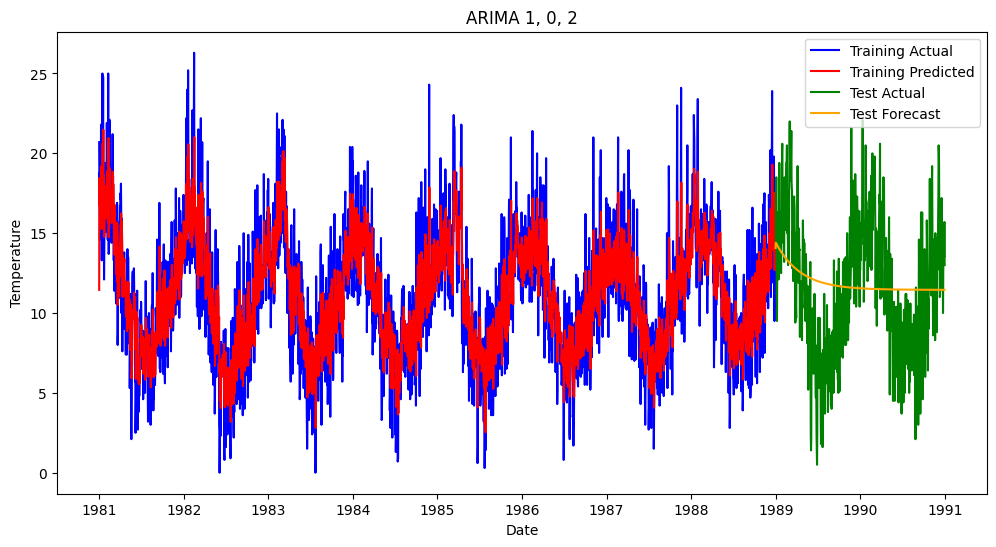

In [52]:
best_model = ARIMA(train_data['Temperature'], order=(1, 0, 2))
best_fit = best_model.fit()

train_pred = best_fit.predict(start=0, end=len(train_data)-1)

# Forecast on test set
test_data['ARMA'] = best_fit.forecast(steps=len(test_data))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Temperature'], label="Training Actual", color="blue")
plt.plot(train_data.index, train_pred, label="Training Predicted", color="red")
plt.plot(test_data.index, test_data['Temperature'], label="Test Actual", color="green")
plt.plot(test_data.index, test_data['ARMA'], label="Test Forecast", color="orange")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"ARIMA 1, 0, 2")
plt.legend()
plt.show()


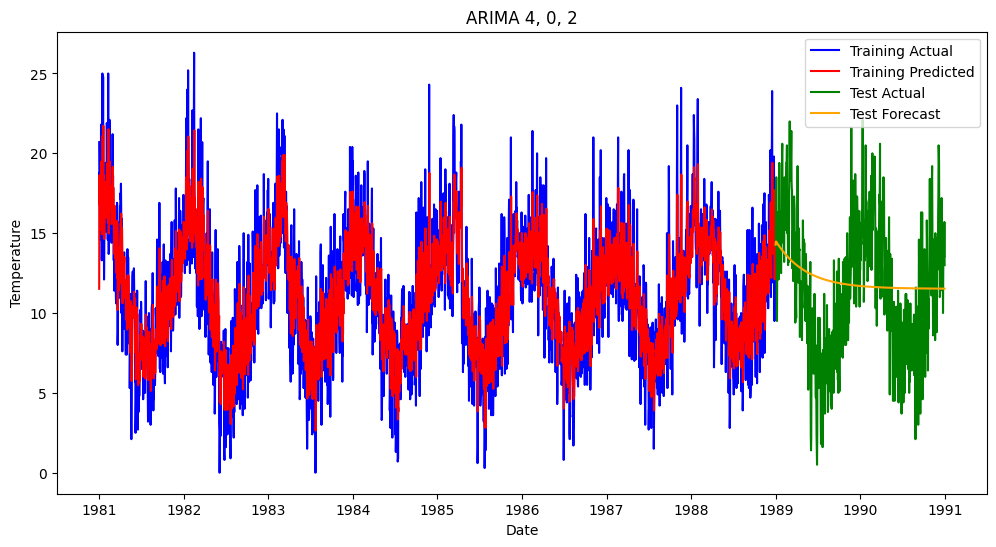

In [53]:
best_model = ARIMA(train_data['Temperature'], order=(4,0,2))
best_fit = best_model.fit()

train_pred = best_fit.predict(start=0, end=len(train_data)-1)

# Forecast on test set
test_data['ARMA'] = best_fit.forecast(steps=len(test_data))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Temperature'], label="Training Actual", color="blue")
plt.plot(train_data.index, train_pred, label="Training Predicted", color="red")
plt.plot(test_data.index, test_data['Temperature'], label="Test Actual", color="green")
plt.plot(test_data.index, test_data['ARMA'], label="Test Forecast", color="orange")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"ARIMA 4, 0, 2")
plt.legend()
plt.show()


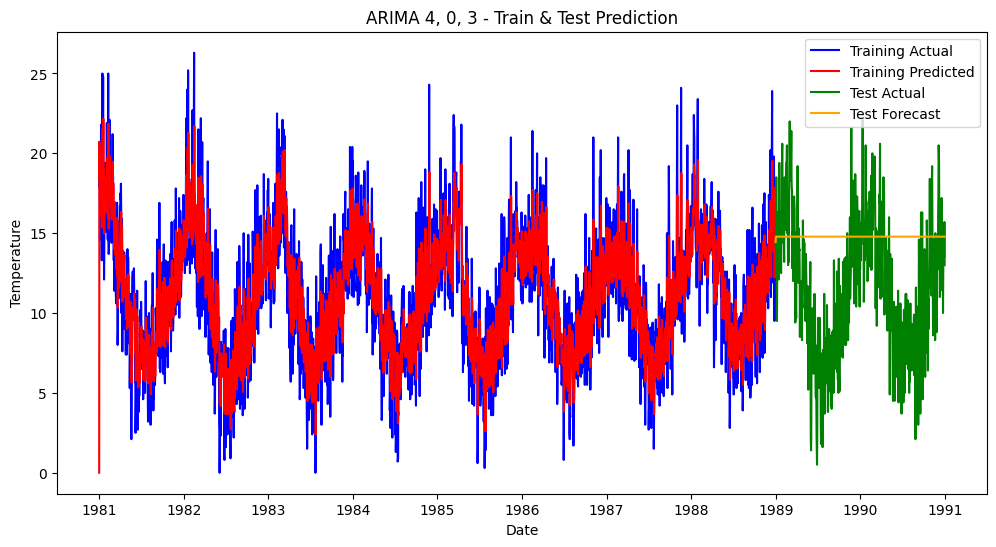

In [54]:
best_model = ARIMA(train_data['Temperature'], order=(2,1,1))
best_fit = best_model.fit()

train_pred = best_fit.predict(start=0, end=len(train_data)-1)

# Forecast on test set
test_data['ARMA'] = best_fit.forecast(steps=len(test_data))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Temperature'], label="Training Actual", color="blue")
plt.plot(train_data.index, train_pred, label="Training Predicted", color="red")
plt.plot(test_data.index, test_data['Temperature'], label="Test Actual", color="green")
plt.plot(test_data.index, test_data['ARMA'], label="Test Forecast", color="orange")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"ARIMA 4, 0, 3 - Train & Test Prediction")
plt.legend()
plt.show()


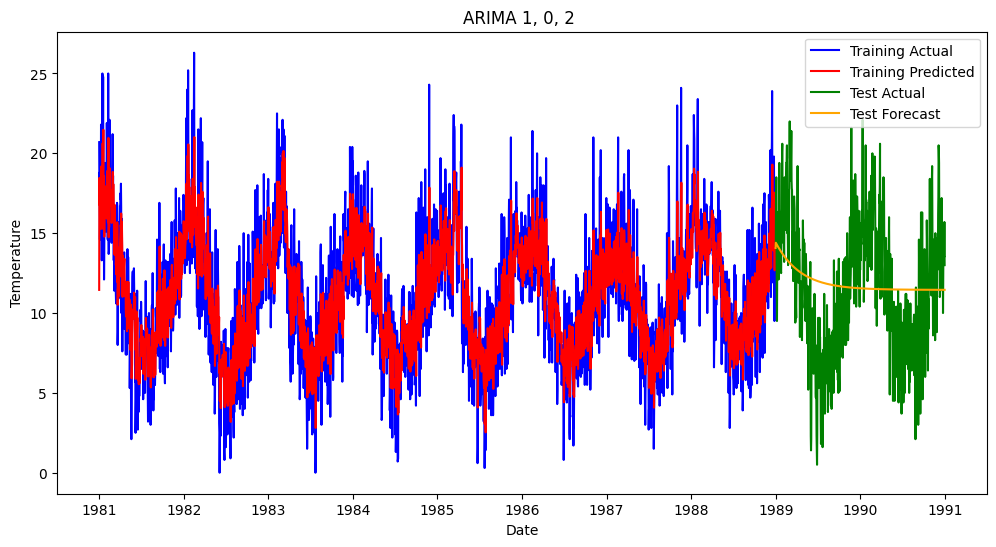

In [55]:
best_model = ARIMA(train_data['Temperature'], order=(1,0,2))
best_fit = best_model.fit()

train_pred = best_fit.predict(start=0, end=len(train_data)-1)

# Forecast on test set
test_data['ARMA'] = best_fit.forecast(steps=len(test_data))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Temperature'], label="Training Actual", color="blue")
plt.plot(train_data.index, train_pred, label="Training Predicted", color="red")
plt.plot(test_data.index, test_data['Temperature'], label="Test Actual", color="green")
plt.plot(test_data.index, test_data['ARMA'], label="Test Forecast", color="orange")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"ARIMA 1, 0, 2 ")
plt.legend()
plt.show()


SARIMAX (ARIMA with Seasonal)

In [30]:
results = []

# Define seasonal period (for daily temperature = 365 days per year , 12 for monthly , 7 for weakly)
seasonal_period = 90

# Loop through p, d, q and seasonal P, D, Q
for p in range(0, 5):      # non-seasonal AR
    for d in range(0, 1):  # non-seasonal differencing
        for q in range(0, 3):  # non-seasonal MA
            for P in range(0, 2):   # seasonal AR (keep small for speed)
                for D in range(0, 2):  # seasonal differencing
                    for Q in range(0, 2):  # seasonal MA
                        try:
                            model = SARIMAX(
                                train_data,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, seasonal_period),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            model_fit = model.fit(disp=False)


                            train_pred = model_fit.predict(start=0, end=len(train_data)-1)
                            train_rmse = np.sqrt(mean_squared_error(train_data, train_pred))
                            train_r2 = r2_score(train_data, train_pred)


                            test_pred = model_fit.forecast(steps=len(test_data))
                            test_rmse = np.sqrt(mean_squared_error(test_data, test_pred))
                            test_r2 = r2_score(test_data, test_pred)


                            results.append({
                                'p': p, 'd': d, 'q': q,
                                'P': P, 'D': D, 'Q': Q,
                                'AIC': model_fit.aic,
                                'BIC': model_fit.bic,
                                'Train_RMSE': train_rmse,
                                'Train_R2': train_r2,
                                'Test_RMSE': test_rmse,
                                'Test_R2': test_r2
                            })

                        except Exception as e:
                            print(f"Error with parameters (p,d,q) = ({p},{d},{q}) and seasonal (P,D,Q) = ({P},{D},{Q}): {e}")
                            continue


if results:
    results_df = pd.DataFrame(results)

    # Sort by Test_RMSE
    results_df = results_df.sort_values(by="Test_RMSE").reset_index(drop=True)

    # Show top 10 models
    print(results_df.head(10))
else:
    print("No valid SARIMAX models were fitted.")

KeyboardInterrupt: 

In [58]:
results_df = results_df.sort_values(by="AIC").reset_index(drop=True)
results_df.head(10)

p  d  q  P  D  Q           AIC           BIC  Train_RMSE  Train_R2  \
0  4  0  1  1  0  0  13470.654829  13512.474150    2.498857  0.620285   
1  4  0  1  1  1  1  13471.710297  13519.470691    2.546455  0.605682   
2  4  0  2  1  1  1  13472.378571  13526.109015    2.546579  0.605644   
3  2  0  2  0  1  1  13473.189269  13509.011638    2.546762  0.605587   
4  3  0  2  0  1  1  13473.343353  13515.136118    2.545667  0.605926   
5  3  0  1  1  1  1  13473.379139  13515.171903    2.545804  0.605884   
6  4  0  2  0  1  1  13474.691845  13522.455004    2.546571  0.605646   
7  2  0  2  1  1  1  13475.188959  13516.981723    2.546762  0.605587   
8  3  0  2  1  1  1  13475.336577  13523.099736    2.545648  0.605932   
9  4  0  2  1  0  0  13476.292853  13524.086363    2.493994  0.621762   

   Test_RMSE   Test_R2  
0   4.230450 -0.063487  
1   3.950844  0.072447  
2   3.951171  0.072294  
3   3.952880  0.071491  
4   3.950642  0.072542  
5   3.950066  0.072812  
6   3.950593  0.072565  
7   3.952944  0.071461  
8   3.950482  0.072617  
9   4.247177 -0.071913

In [78]:
best_model = SARIMAX(train_data['Temperature'], order=(4,0,1), seasonal_order=(1,1,1,90), enforce_stationarity=False, enforce_invertibility=False)
best_fit = best_model.fit()

train_pred = best_fit.predict(start=0, end=len(train_data)-1)

# Forecast on test set
test_data['SARIMAX'] = best_fit.forecast(steps=len(test_data))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Temperature'], label="Training Actual", color="blue")
plt.plot(train_data.index, train_pred, label="Training Predicted", color="red")
plt.plot(test_data.index, test_data['Temperature'], label="Test Actual", color="green")
plt.plot(test_data.index, test_data['SARIMAX'], label="Test Forecast", color="orange")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"SARIMAX order=(4,0,1), seasonal_order=(1,1,1,365)")
plt.legend()
plt.show()

KeyboardInterrupt: 

SimpleRNN

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training data only
train_scaled = scaler.fit_transform(train_data[['Temperature']])
test_scaled = scaler.transform(test_data[['Temperature']])


In [20]:
window_size = 30

In [21]:
def create_sequences(data, window_size=30):
    """Create sequences of length window_size for RNN input"""
    xs, ys = [], []
    for i in range(len(data) - window_size):
        x = data[i:(i+window_size)]
        y = data[i+window_size]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)





In [22]:
train_scaled = train_data['Temperature'].values
test_scaled = test_data['Temperature'].values

# Create training sequences
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(np.concatenate([train_scaled[-window_size:], test_scaled]), window_size)

# Reshape for RNN: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [47]:
#RNN model
rnn_model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse')

#Train model
history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1)


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 107.7415 - val_loss: 15.8222
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 15.4854 - val_loss: 9.6247
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.2117 - val_loss: 8.2533
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8622 - val_loss: 7.6647
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2805 - val_loss: 7.1776
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2247 - val_loss: 7.1540
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8977 - val_loss: 6.9099
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5522 - val_loss: 6.7285
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3402 - val_loss: 6.4634
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4567 - val_loss: 6.3748
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9722 - val_loss: 6.4284
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

In [55]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,869 (50.27 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,580 (33.52 KB)

In [48]:
# Predictions
train_pred_rnn = rnn_model.predict(X_train)
test_pred_rnn = rnn_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_rnn))
train_r2 = r2_score(y_train, train_pred_rnn)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_rnn))
test_r2 = r2_score(y_test, test_pred_rnn)

print("RNN Results:")
print(f"Train RMSE: {train_rmse:.3f}, Train R²: {train_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}, Test R²: {test_r2:.3f}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RNN Results:
Train RMSE: 2.407, Train R²: 0.639
Test RMSE: 2.207, Test R²: 0.711


In [ ]:
rnn_results_df = pd.DataFrame([{
    'p': 'RNN', 'd': '-', 'q': '-',
    'AIC': np.nan, 'BIC': np.nan,
    'Train_RMSE': train_rmse,
    'Train_R2': train_r2,
    'Test_RMSE': test_rmse,
    'Test_R2': test_r2
}])

results_df = pd.concat([results_df, rnn_results_df], ignore_index=True)

# Sort by Test_RMSE again
results_df = results_df.sort_values(by="Test_RMSE").reset_index(drop=True)

print(results_df.tail())  # Show last rows including RNN

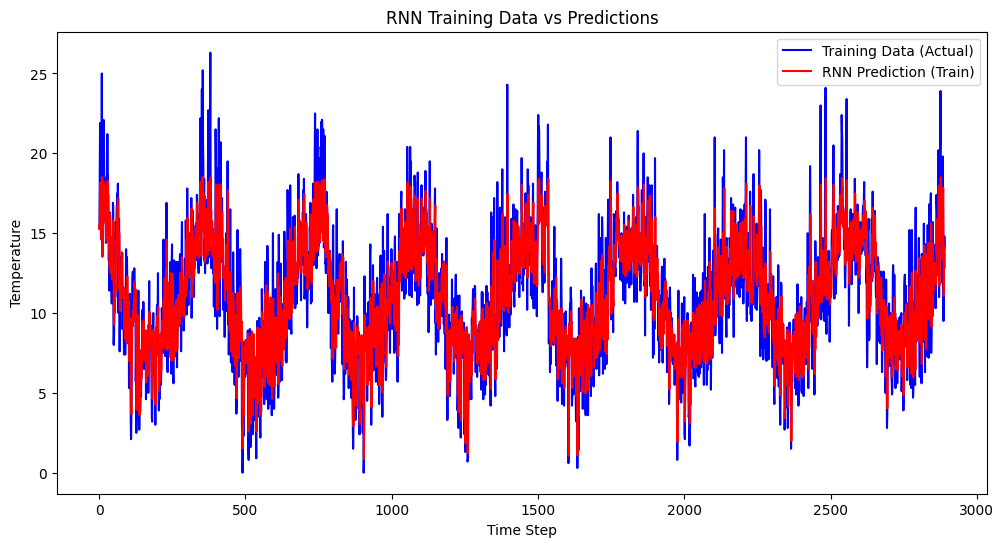

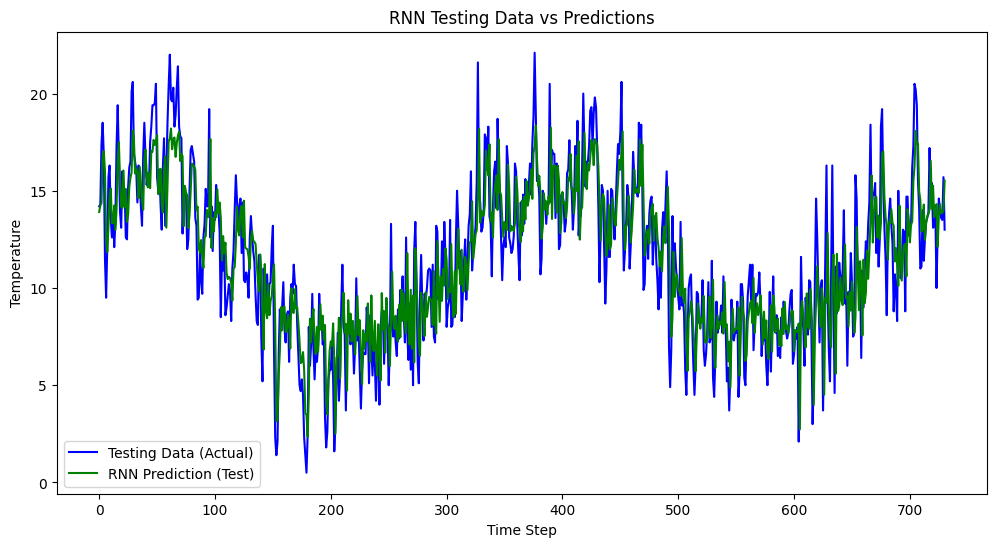

In [49]:

# Plot Training Data
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_rnn, label="RNN Prediction (Train)", color="red")
plt.title("RNN Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

# Plot Testing Data
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_rnn, label="RNN Prediction (Test)", color="green")
plt.title("RNN Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


LSTM (Long Short-Term Memory)

In [56]:
# LSTM model
lstm_model = Sequential([
    LSTM(64, activation="tanh", input_shape=(window_size, 1)),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")

# Train model
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_split=0.1
)


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 78.1208 - val_loss: 13.7828
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8658 - val_loss: 8.4680
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6835 - val_loss: 7.5617
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5132 - val_loss: 6.8963
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0548 - val_loss: 6.6445
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6660 - val_loss: 6.5988
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6594 - val_loss: 6.4296
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5907 - val_loss: 6.4745
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3714 - val_loss: 6.3217
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3264 - val_loss: 6.4567
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.7571 - val_loss: 6.2126
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 

In [57]:
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,885 (198.77 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,924 (132.52 KB)

In [58]:
# Predictions
train_pred_lstm = lstm_model.predict(X_train)
test_pred_lstm = lstm_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_lstm))
train_r2 = r2_score(y_train, train_pred_lstm)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_lstm))
test_r2 = r2_score(y_test, test_pred_lstm)

print("LSTM Results:")
print(f"Train RMSE: {train_rmse:.3f}, Train R²: {train_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}, Test R²: {test_r2:.3f}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RNN Results:
Train RMSE: 2.388, Train R²: 0.645
Test RMSE: 2.171, Test R²: 0.720


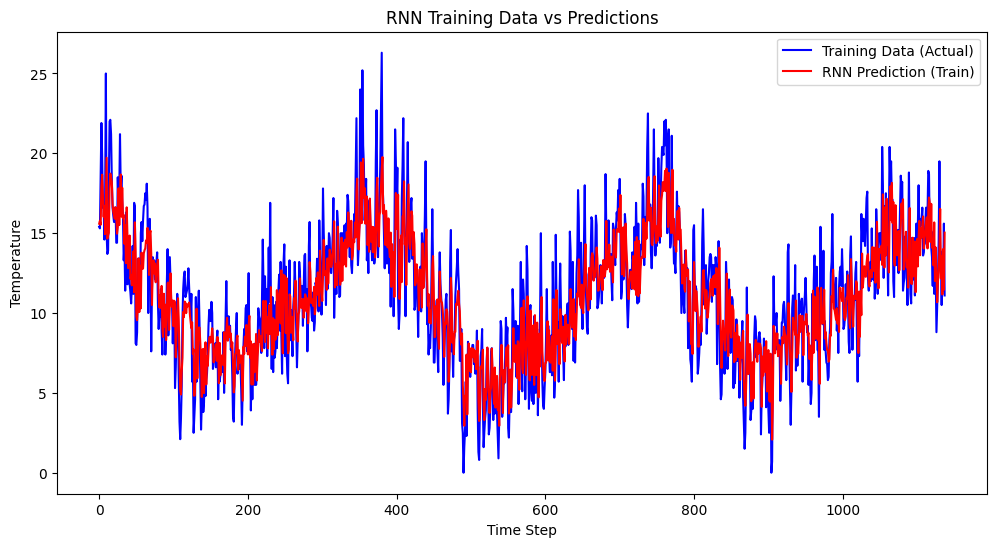

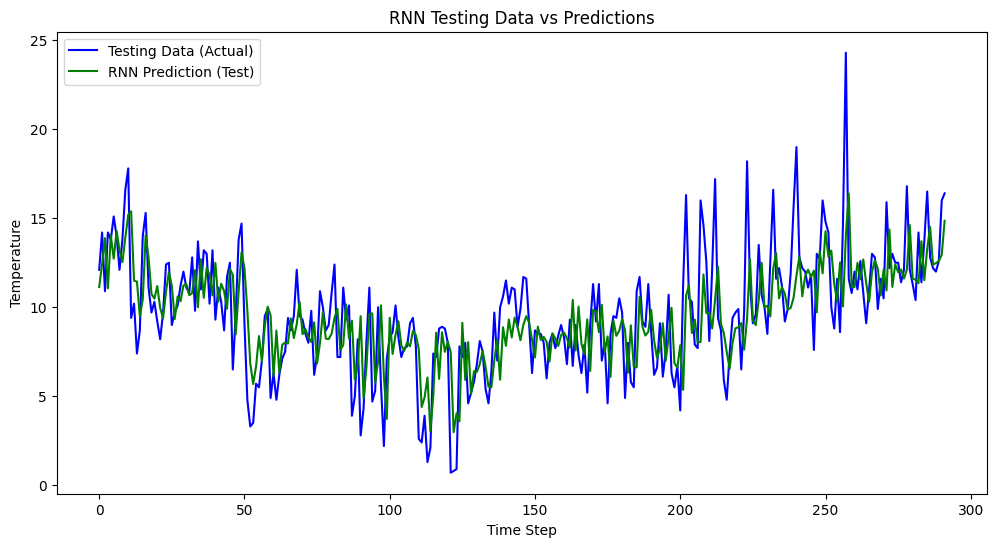

In [95]:

# Plot Training Data
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_lstm, label="RNN Prediction (Train)", color="red")
plt.title("RNN Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

# Plot Testing Data
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_lstm, label="RNN Prediction (Test)", color="green")
plt.title("RNN Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


In [75]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1), dropout=0.2),
    LSTM(32, dropout=0.2),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 89.0474 - val_loss: 22.4007
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.7009 - val_loss: 14.0662
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.4125 - val_loss: 12.6536
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.7833 - val_loss: 12.5048
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.4414 - val_loss: 12.4686
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.1747 - val_loss: 12.3522
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.5545 - val_loss: 12.4160
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.3581 - val_loss: 10.3722
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.6734 - val_loss: 13.9759
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.6267 - val_loss: 13.6909
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.2493 - val_loss: 9.6393
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━

In [79]:
lstm_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

In [77]:
train_pred_lstm = lstm_model.predict(X_train)
test_pred_lstm = lstm_model.predict(X_test)


train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_lstm))
train_r2 = r2_score(y_train, train_pred_lstm)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_lstm))
test_r2 = r2_score(y_test, test_pred_lstm)

print("LSTM Results")
print(f"Train → RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Test  → RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Results
Train → RMSE: 2.950, R²: 0.458
Test  → RMSE: 2.791, R²: 0.537


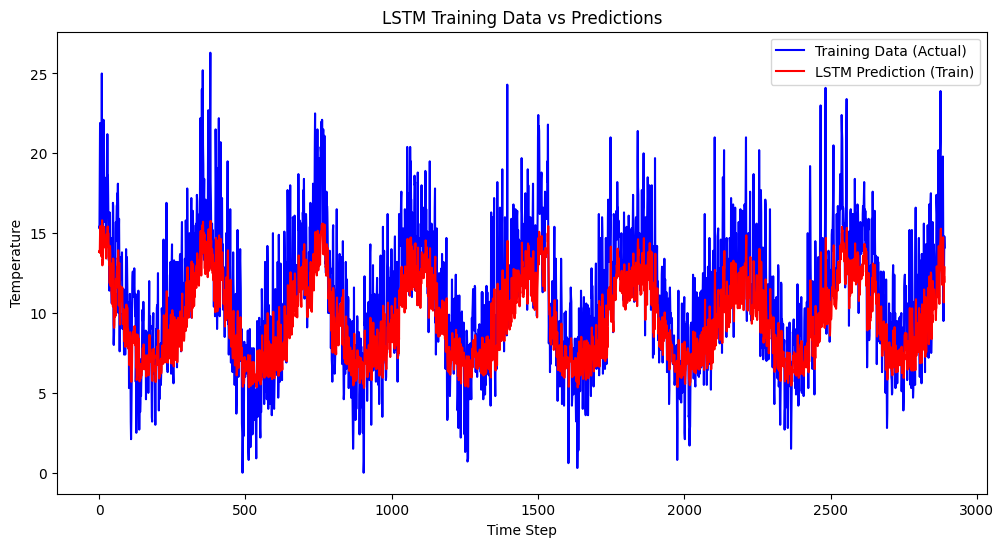

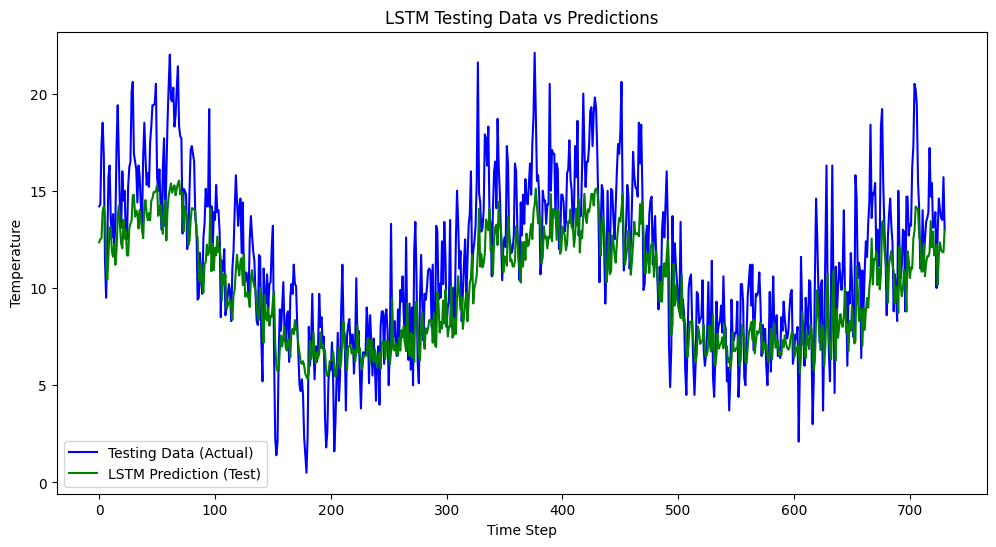

In [78]:
# Plot Training Data
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_lstm, label="LSTM Prediction (Train)", color="red")
plt.title("LSTM Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

# Plot Testing Data
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_lstm, label="LSTM Prediction (Test)", color="green")
plt.title("LSTM Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


GRU (Gated Recurrent Unit)

In [84]:

# GRU model
gru_model = Sequential([
    GRU(132, activation="tanh", input_shape=(window_size,1)),
    Dense(1)
])

gru_model.compile(optimizer="adam", loss="mse")

# Train GRU
history = gru_model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    verbose=1,
    validation_split=0.1
)


Epoch 1/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 45.8345 - val_loss: 7.3954
Epoch 2/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1945 - val_loss: 6.8451
Epoch 3/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6844 - val_loss: 6.5446
Epoch 4/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5567 - val_loss: 6.7357
Epoch 5/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2634 - val_loss: 6.4250
Epoch 6/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4236 - val_loss: 6.2322
Epoch 7/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9666 - val_loss: 6.1357
Epoch 8/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3655 - val_loss: 6.2345
Epoch 9/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8086 - val_loss: 6.1425
Epoch 10/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1446 - val_loss: 6.1285
Epoch 11/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7510 - val_loss: 6.3935
Epoch 12/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

In [86]:
train_pred_gru = gru_model.predict(X_train)
test_pred_gru = gru_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_gru))
train_r2 = r2_score(y_train, train_pred_gru)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_gru))
test_r2 = r2_score(y_test, test_pred_gru)

print("GRU Results")
print(f"Train → RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Test  → RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
GRU Results
Train → RMSE: 1.053, R²: 0.931
Test  → RMSE: 3.078, R²: 0.437


In [85]:
gru_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 132)            │        53,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           133 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,781 (628.05 KB)

 Trainable params: 53,593 (209.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 107,188 (418.71 KB)

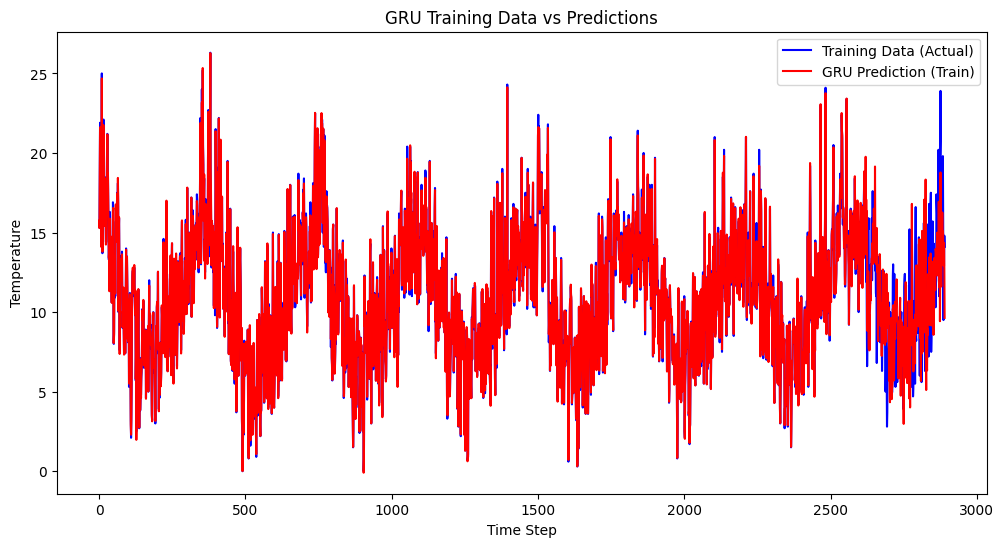

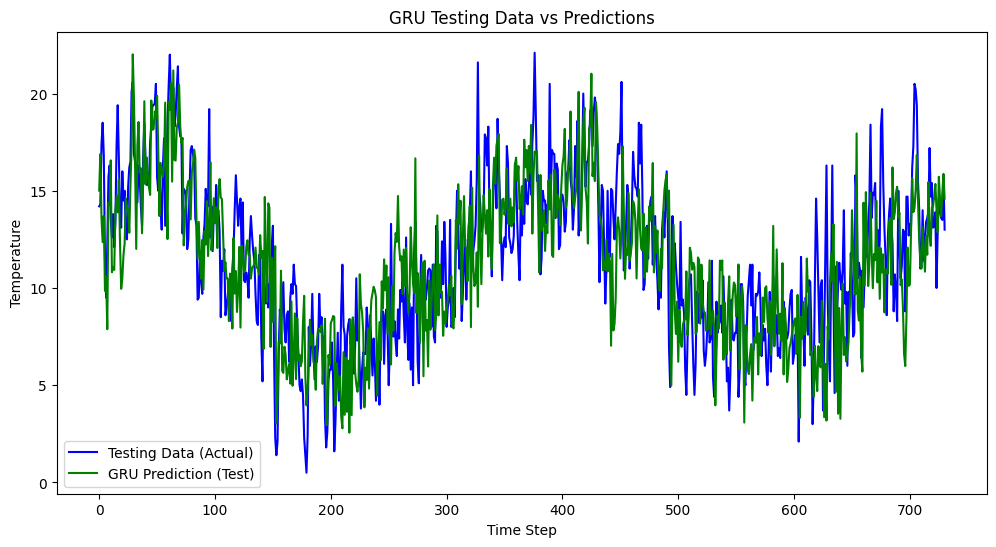

In [87]:
#Training Data vs GRU Prediction
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_gru, label="GRU Prediction (Train)", color="red")
plt.title("GRU Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

#Testing Data vs GRU Prediction
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_gru, label="GRU Prediction (Test)", color="green")
plt.title("GRU Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


In [99]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Build GRU model with 3 layers
gru_model = Sequential([
    GRU(132, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.1),  # first dropout layer

    GRU(64, activation='tanh', return_sequences=True),
    Dropout(0.1),  # second dropout layer

    GRU(32, activation='tanh'),
    Dense(1)  # output layer
])

# Compile model
gru_model.compile(optimizer='adam', loss='mse')

# Train model
history = gru_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stop]
)


Epoch 1/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 55.9099 - val_loss: 15.1588
Epoch 2/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 18.6131 - val_loss: 12.7280
Epoch 3/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 16.8364 - val_loss: 12.5078
Epoch 4/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 16.0126 - val_loss: 11.1620
Epoch 5/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.5013 - val_loss: 8.4116
Epoch 6/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9146 - val_loss: 6.7566
Epoch 7/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.1952 - val_loss: 6.4487
Epoch 8/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8033 - val_loss: 6.8358
Epoch 9/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.1389 - val_loss: 6.3346
Epoch 10/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.4092 - val_loss: 6.5761
Epoch 11/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.4611 - val_loss: 6.5237
Epoch 12/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/ste

In [100]:
gru_model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                    │ (None, 30, 132)        │        53,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 30, 64)         │        38,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,753 (1.15 MB)

 Trainable params: 100,917 (394.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,836 (788.43 KB)

In [101]:
train_pred_gru = gru_model.predict(X_train)
test_pred_gru = gru_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_gru))
train_r2 = r2_score(y_train, train_pred_gru)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_gru))
test_r2 = r2_score(y_test, test_pred_gru)

print("GRU Results")
print(f"Train → RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Test  → RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU Results
Train → RMSE: 2.396, R²: 0.642
Test  → RMSE: 2.200, R²: 0.712


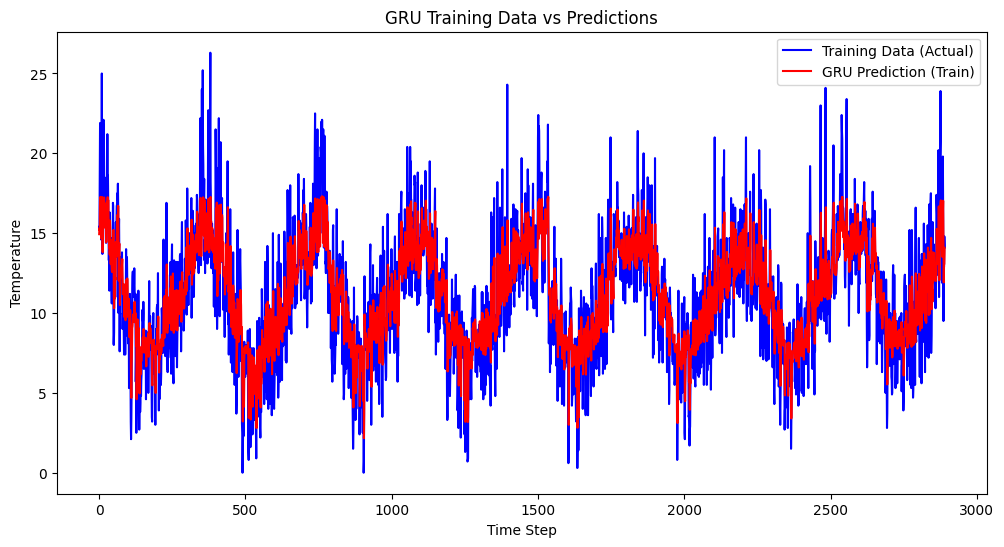

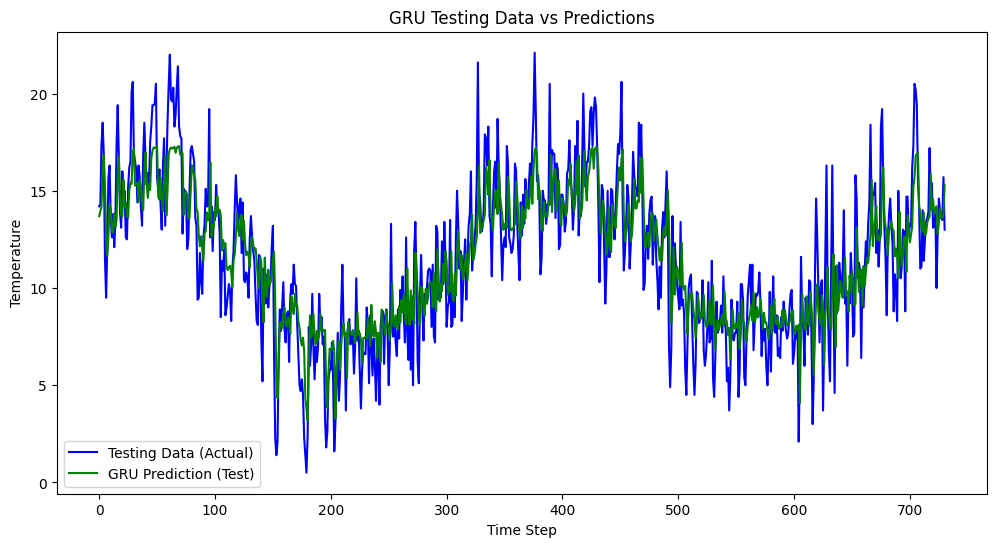

In [102]:
#Training Data vs GRU Prediction
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_gru, label="GRU Prediction (Train)", color="red")
plt.title("GRU Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

#Testing Data vs GRU Prediction
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_gru, label="GRU Prediction (Test)", color="green")
plt.title("GRU Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


Bidirectional RNNs



In [103]:
# Bidirectional RNN model
bidir_model = Sequential([
    Bidirectional(SimpleRNN(64, activation="tanh"), input_shape=(window_size, 1)),
    Dense(1)
])

bidir_model.compile(optimizer="adam", loss="mse")

# Train model
history = bidir_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    verbose=1,
    validation_split=0.1
)

Epoch 1/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 62.9972 - val_loss: 9.2138
Epoch 2/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.5595 - val_loss: 7.4133
Epoch 3/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4471 - val_loss: 6.8969
Epoch 4/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1612 - val_loss: 6.7080
Epoch 5/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4560 - val_loss: 6.6757
Epoch 6/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6325 - val_loss: 6.4584
Epoch 7/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4430 - val_loss: 6.3655
Epoch 8/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2554 - val_loss: 6.3159
Epoch 9/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2330 - val_loss: 6.3848
Epoch 10/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8086 - val_loss: 6.3932
Epoch 11/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3253 - val_loss: 6.3807
Epoch 12/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5

In [105]:
bidir_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,733 (100.52 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,156 (67.02 KB)

In [106]:
# Predictions
train_pred_bidir = bidir_model.predict(X_train)
test_pred_bidir = bidir_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_bidir))
train_r2 = r2_score(y_train, train_pred_bidir)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_bidir))
test_r2 = r2_score(y_test, test_pred_bidir)

print("Bidirectional RNN Results")
print(f"Train → RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Test  → RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Bidirectional RNN Results
Train → RMSE: 1.816, R²: 0.795
Test  → RMSE: 2.800, R²: 0.534


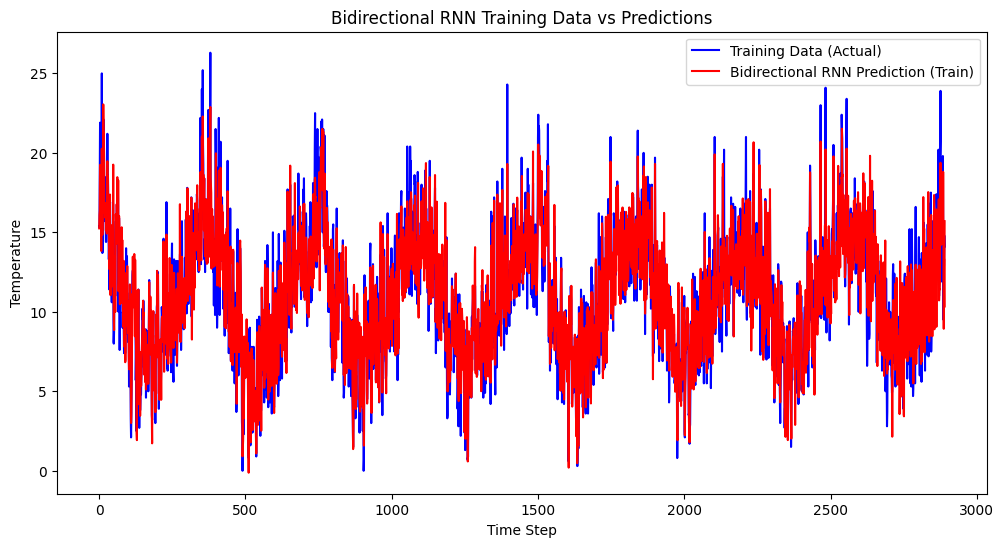

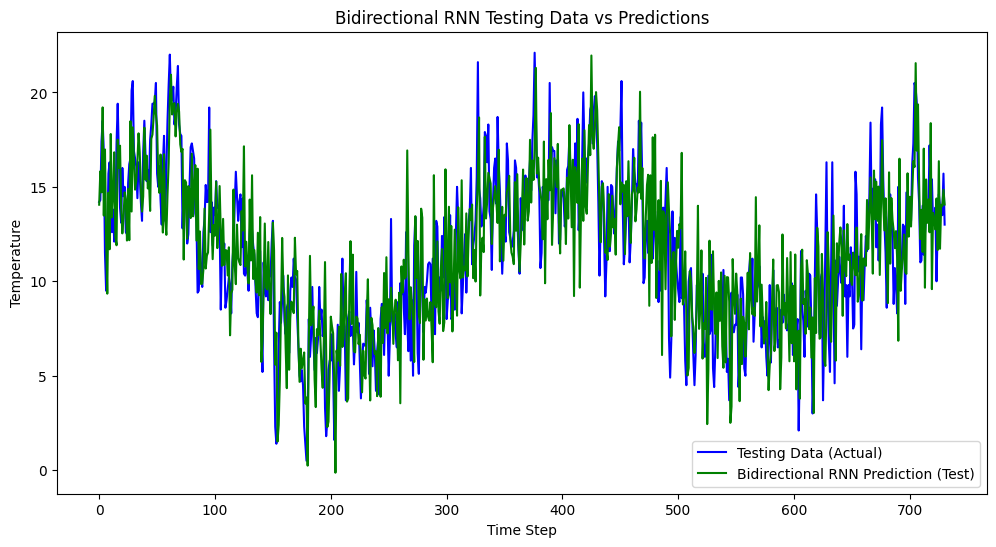

In [107]:
#Training Data vs BiRNN Prediction
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_bidir, label="Bidirectional RNN Prediction (Train)", color="red")
plt.title("Bidirectional RNN Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

#Testing Data vs BiRNN Prediction
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_bidir, label="Bidirectional RNN Prediction (Test)", color="green")
plt.title("Bidirectional RNN Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


In [117]:
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


bidir_model = Sequential([
    Bidirectional(SimpleRNN(132, return_sequences=True), input_shape=(window_size, 1)),
    Dropout(0.2),

    Bidirectional(SimpleRNN(64, return_sequences=True)),
    LeakyReLU(alpha=0.1),
    Dropout(0.1),

    Bidirectional(SimpleRNN(16, return_sequences=True)),
    LeakyReLU(alpha=0.1),
    Dropout(0.1),

    Bidirectional(SimpleRNN(32)),
    Dense(16, activation="relu"),
    Dense(1)
])

# Optimizer with gradient clipping for stability
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

bidir_model.compile(optimizer=optimizer, loss="mse")


history = bidir_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stop]
)


Epoch 1/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - loss: 62.3395 - val_loss: 8.9502
Epoch 2/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.8188 - val_loss: 7.0451
Epoch 3/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.8415 - val_loss: 6.4678
Epoch 4/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.9955 - val_loss: 6.4683
Epoch 5/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.8051 - val_loss: 6.6294
Epoch 6/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.5442 - val_loss: 6.6495
Epoch 7/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.4056 - val_loss: 6.7439
Epoch 8/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.6673 - val_loss: 7.2598
Epoch 9/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.3041 - val_loss: 6.4616
Epoch 10/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.2640 - val_loss: 6.5595
Epoch 11/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.4237 - val_loss: 6.9123
Epoch 12/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/s

In [119]:
bidir_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_11                │ (None, 30, 264)        │        35,376 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 30, 264)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 30, 128)        │        42,112 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 30, 32)         │         4,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 64)             │         4,160 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,037 (1023.59 KB)

 Trainable params: 87,345 (341.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 174,692 (682.39 KB)

In [120]:
# Predictions
train_pred_bidir = bidir_model.predict(X_train)
test_pred_bidir = bidir_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_bidir))
train_r2 = r2_score(y_train, train_pred_bidir)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_bidir))
test_r2 = r2_score(y_test, test_pred_bidir)

print("Bidirectional RNN Results")
print(f"Train → RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Test  → RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Bidirectional RNN Results
Train → RMSE: 2.373, R²: 0.649
Test  → RMSE: 2.214, R²: 0.709


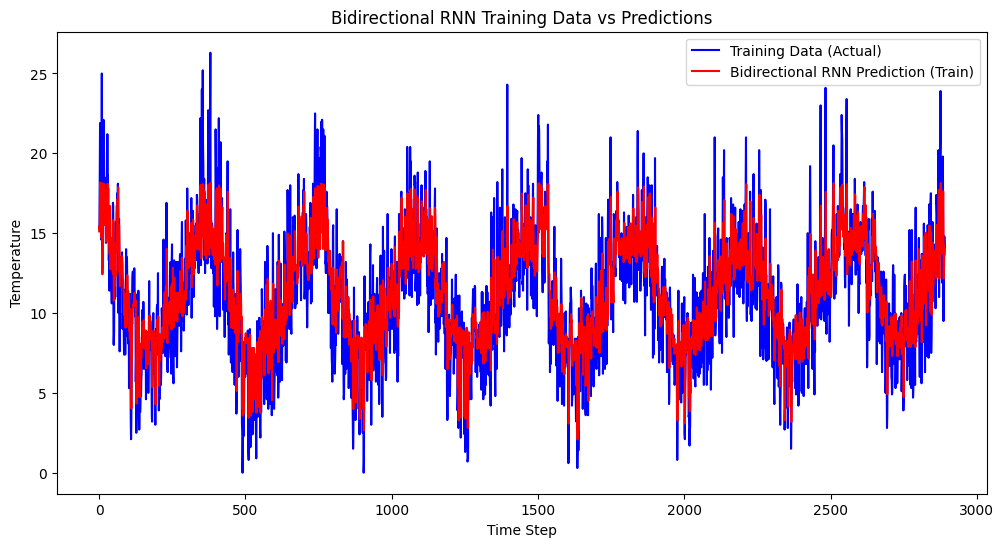

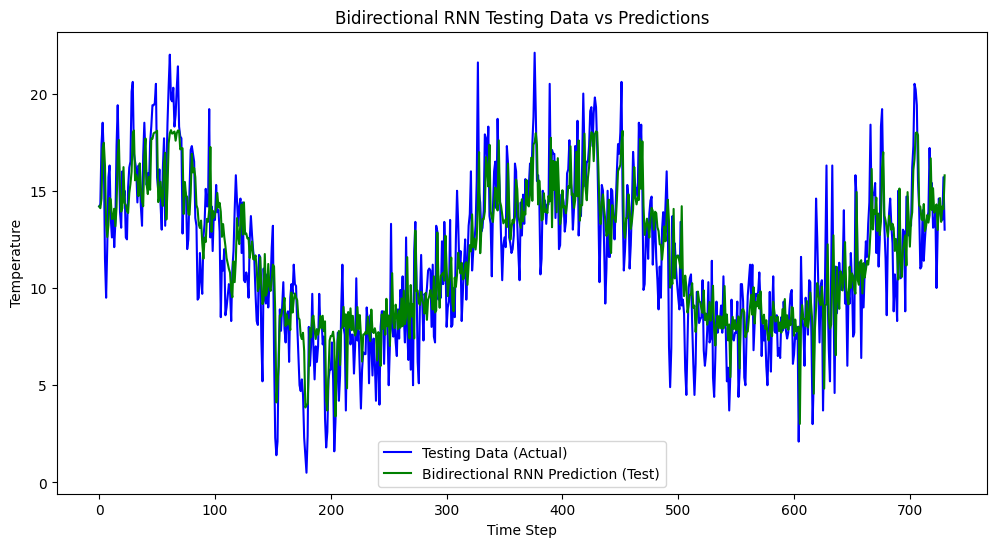

In [121]:
#Training Data vs BiRNN Prediction
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_bidir, label="Bidirectional RNN Prediction (Train)", color="red")
plt.title("Bidirectional RNN Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

#Testing Data vs BiRNN Prediction
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_bidir, label="Bidirectional RNN Prediction (Test)", color="green")
plt.title("Bidirectional RNN Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


Stacked (Deep) RNNs

In [123]:
# Stacked (Deep) RNN model
stacked_rnn_model = Sequential([
    SimpleRNN(64, activation="tanh", return_sequences=True, input_shape=(window_size, 1)),
    SimpleRNN(64, activation="tanh"),  # Second RNN layer
    Dense(1)
])

stacked_rnn_model.compile(optimizer="adam", loss="mse")

history = stacked_rnn_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    verbose=1,
    validation_split=0.1
)

Epoch 1/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 53.3341 - val_loss: 10.7897
Epoch 2/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.1879 - val_loss: 7.4705
Epoch 3/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2226 - val_loss: 7.1624
Epoch 4/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5423 - val_loss: 6.4609
Epoch 5/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5968 - val_loss: 6.4009
Epoch 6/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0964 - val_loss: 6.7677
Epoch 7/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5003 - val_loss: 6.5406
Epoch 8/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0072 - val_loss: 6.3842
Epoch 9/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2250 - val_loss: 6.6713
Epoch 10/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7734 - val_loss: 6.2908
Epoch 11/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3053 - val_loss: 6.4212
Epoch 12/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss:

In [124]:
stacked_rnn_model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_18 (SimpleRNN)       │ (None, 30, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,637 (147.02 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,092 (98.02 KB)

In [125]:
# Predictions
train_pred_stacked = stacked_rnn_model.predict(X_train)
test_pred_stacked = stacked_rnn_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_stacked))
train_r2 = r2_score(y_train, train_pred_stacked)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_stacked))
test_r2 = r2_score(y_test, test_pred_stacked)

print("Stacked RNN Results")
print(f"Train → RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Test  → RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Stacked RNN Results
Train → RMSE: 1.111, R²: 0.923
Test  → RMSE: 3.107, R²: 0.427


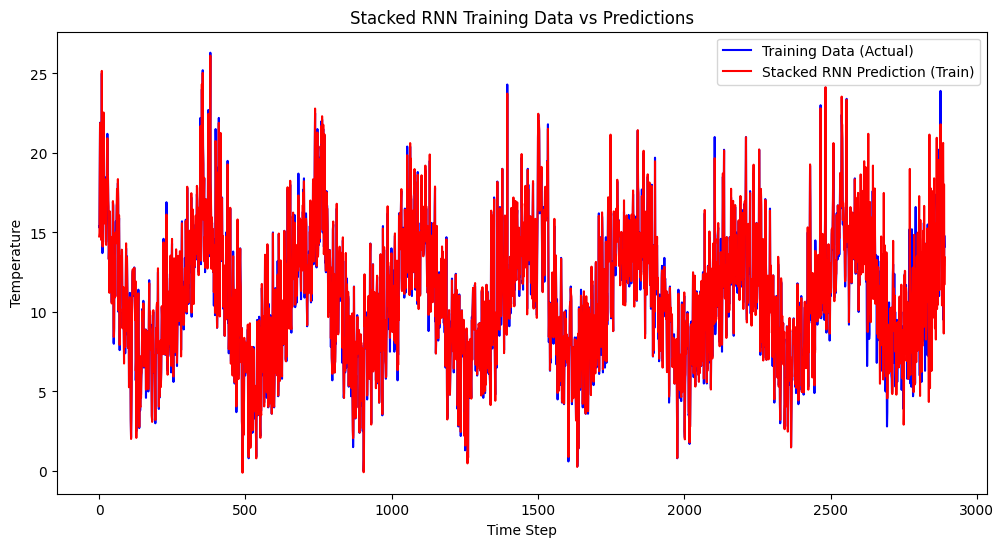

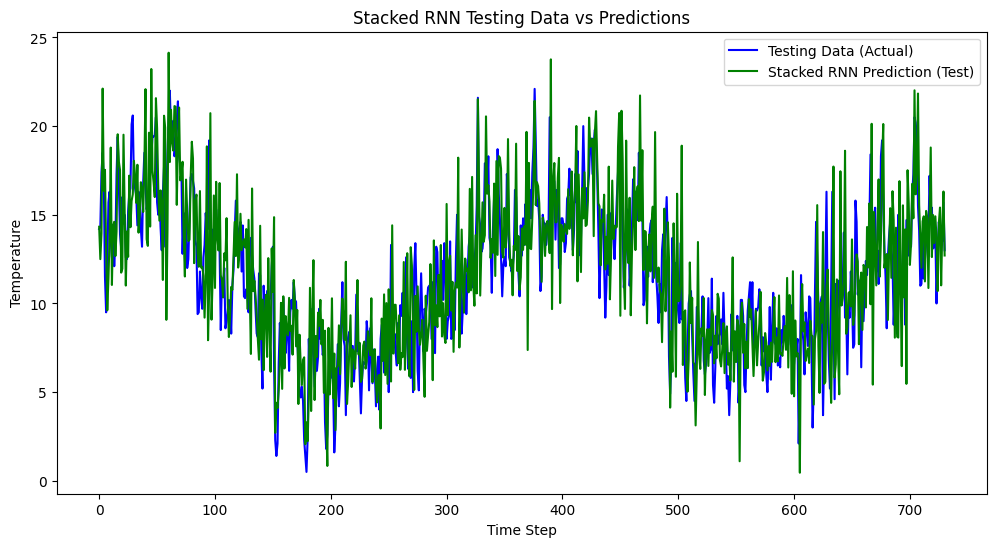

In [126]:
#Training Data vs Stacked RNN Prediction
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_stacked, label="Stacked RNN Prediction (Train)", color="red")
plt.title("Stacked RNN Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

#Testing Data vs Stacked RNN Prediction
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_stacked, label="Stacked RNN Prediction (Test)", color="green")
plt.title("Stacked RNN Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


Hybrid RNN + CNN

In [128]:

hybrid_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    SimpleRNN(64, activation="tanh"),
    Dense(1)
])

hybrid_model.compile(optimizer="adam", loss="mse")

# Train model
history = hybrid_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    verbose=1,
    validation_split=0.1
)

Epoch 1/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 38.3738 - val_loss: 9.6529
Epoch 2/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7866 - val_loss: 7.5230
Epoch 3/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2121 - val_loss: 7.1562
Epoch 4/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0295 - val_loss: 7.5260
Epoch 5/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4213 - val_loss: 6.7031
Epoch 6/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5010 - val_loss: 6.9019
Epoch 7/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5884 - val_loss: 6.6552
Epoch 8/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7081 - val_loss: 6.7030
Epoch 9/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4769 - val_loss: 6.6202
Epoch 10/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1025 - val_loss: 6.6193
Epoch 11/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3989 - val_loss: 6.8948
Epoch 12/500
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6

In [129]:
hybrid_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_21 (SimpleRNN)       │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,205 (75.02 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,804 (50.02 KB)

In [130]:
# Predictions
train_pred_hybrid = hybrid_model.predict(X_train)
test_pred_hybrid = hybrid_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_hybrid))
train_r2 = r2_score(y_train, train_pred_hybrid)

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_hybrid))
test_r2 = r2_score(y_test, test_pred_hybrid)

print("Hybrid CNN + RNN Results")
print(f"Train → RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Test  → RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Hybrid CNN + RNN Results
Train → RMSE: 1.263, R²: 0.901
Test  → RMSE: 3.232, R²: 0.379


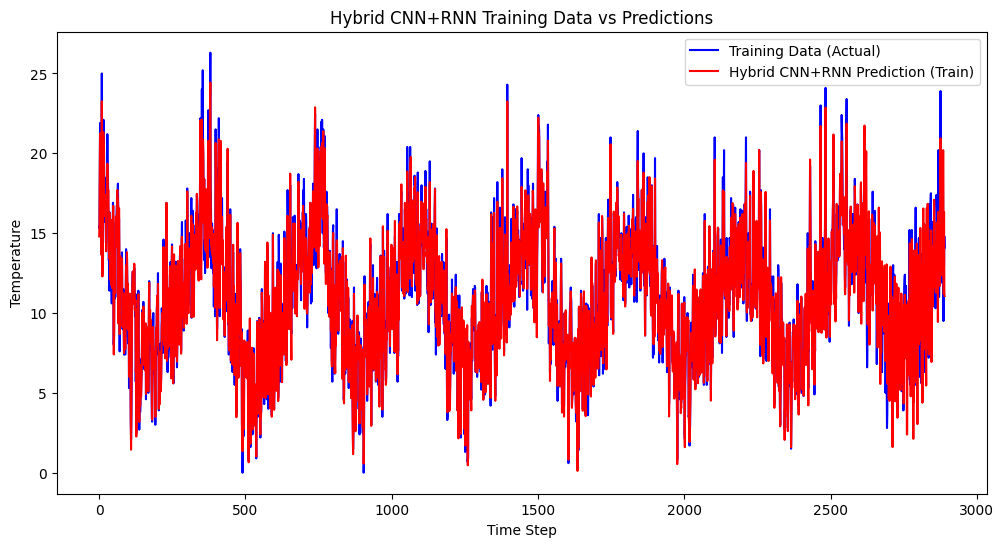

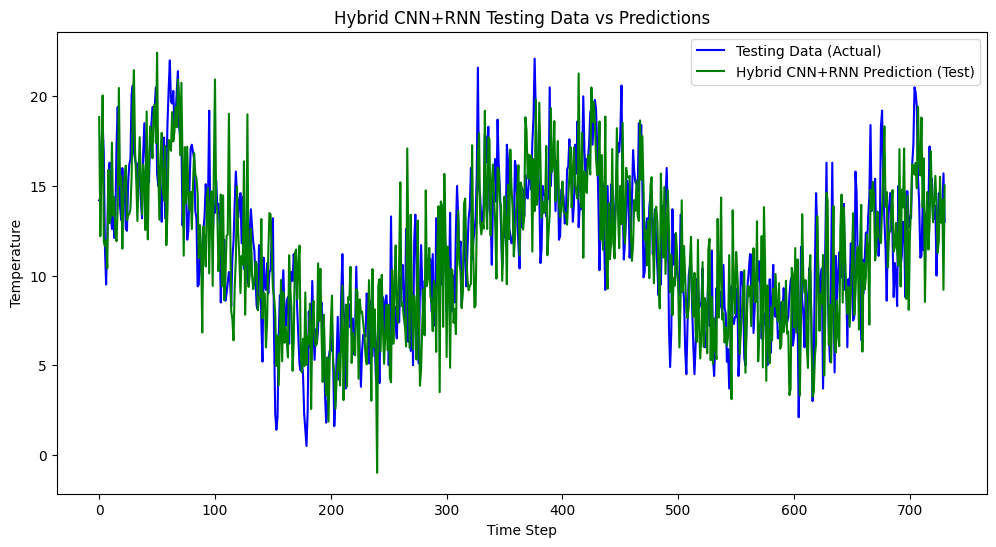

In [131]:
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Training Data (Actual)", color="blue")
plt.plot(train_pred_hybrid, label="Hybrid CNN+RNN Prediction (Train)", color="red")
plt.title("Hybrid CNN+RNN Training Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()

#Testing Data vs Hybrid RNN+CNN Prediction
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Testing Data (Actual)", color="blue")
plt.plot(test_pred_hybrid, label="Hybrid CNN+RNN Prediction (Test)", color="green")
plt.title("Hybrid CNN+RNN Testing Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.show()


### **Prophet**

In [30]:
data.head(5)

Temperature
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8

In [31]:
data = data.reset_index().rename(columns={'index': 'Date'})
data.head()

Date  Temperature
0 1981-01-01         20.7
1 1981-01-02         17.9
2 1981-01-03         18.8
3 1981-01-04         14.6
4 1981-01-05         15.8

In [32]:
data = data.rename(columns={'Date': 'ds', 'Temperature': 'y'})
data['ds'] = pd.to_datetime(data['ds'])

# Prophet expects continuous time data
data = data.sort_values('ds').dropna()

data.head()


ds     y
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3652 non-null   datetime64[ns]
 1   y       3652 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxcrkph3x/knthlnbj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxcrkph3x/42pokaja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3674', 'data', 'file=/tmp/tmpxcrkph3x/knthlnbj.json', 'init=/tmp/tmpxcrkph3x/42pokaja.json', 'output', 'file=/tmp/tmpxcrkph3x/prophet_modelp9wjkle1/prophet_model-20251007165236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:52:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Train → RMSE: 2.745, R²: 0.542
Test → RMSE: 2.937, R²: 0.487


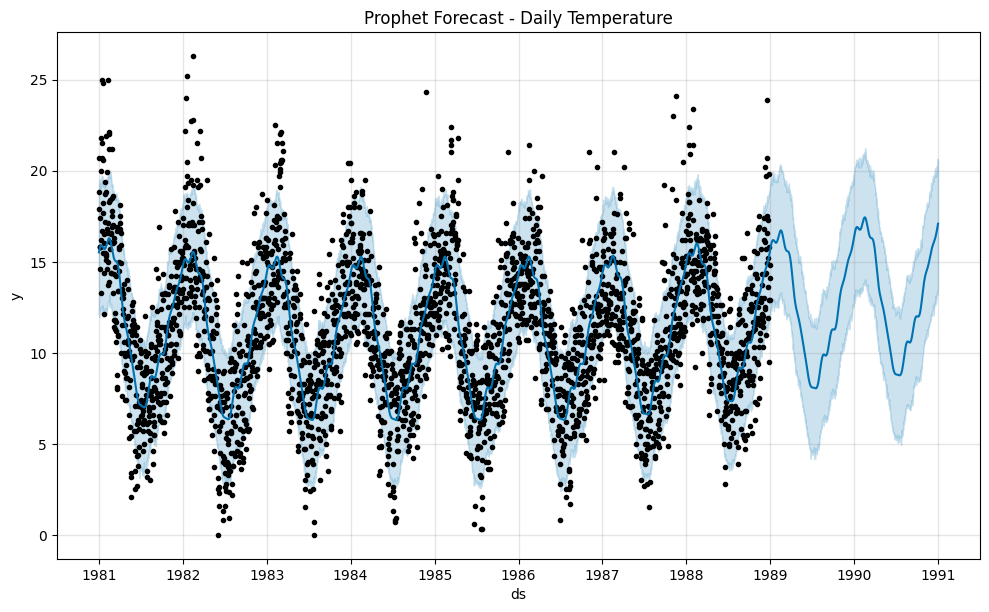

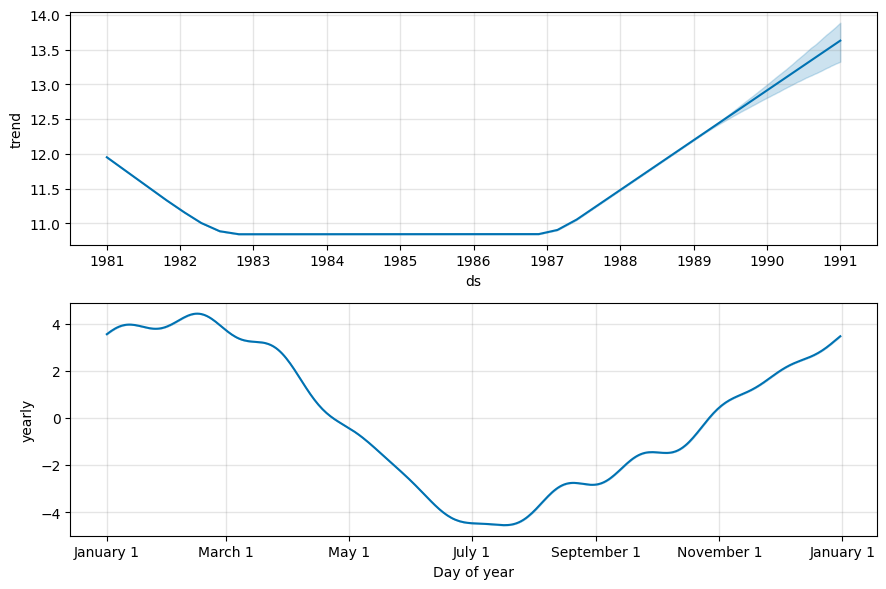

In [34]:
train_size = int(len(data) * 0.8)
train_data_prophet, test_data_prophet = data.iloc[:train_size], data.iloc[train_size:]

# Initialize Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'  # or 'multiplicative'
)

# adding custom seasonalities
prophet_model.add_seasonality(name='yearly', period=365, fourier_order=5)

prophet_model.fit(train_data_prophet)

# Make future dataframe (for the length of the test set)
future = prophet_model.make_future_dataframe(periods=len(test_data_prophet), freq='D')

forecast = prophet_model.predict(future)

# Extract forecast for the test period
forecast_test = forecast.iloc[-len(test_data_prophet):]

# -------------------
# Training set evaluation
# -------------------
forecast_train = forecast.iloc[:len(train_data_prophet)]
rmse_train = np.sqrt(mean_squared_error(train_data_prophet['y'], forecast_train['yhat']))
r2_train = r2_score(train_data_prophet['y'], forecast_train['yhat'])
print(f"Train → RMSE: {rmse_train:.3f}, R²: {r2_train:.3f}")

# -------------------
# Test set evaluation
# -------------------
forecast_test = forecast.iloc[-len(test_data_prophet):]
rmse_test = np.sqrt(mean_squared_error(test_data_prophet['y'], forecast_test['yhat']))
r2_test = r2_score(test_data_prophet['y'], forecast_test['yhat'])
print(f"Test → RMSE: {rmse_test:.3f}, R²: {r2_test:.3f}")


# Plot forecast (includes training and test periods)
fig1 = prophet_model.plot(forecast)
plt.title("Prophet Forecast - Daily Temperature")
plt.show()

# Plot components (trend + seasonality)
fig2 = prophet_model.plot_components(forecast)
plt.show()

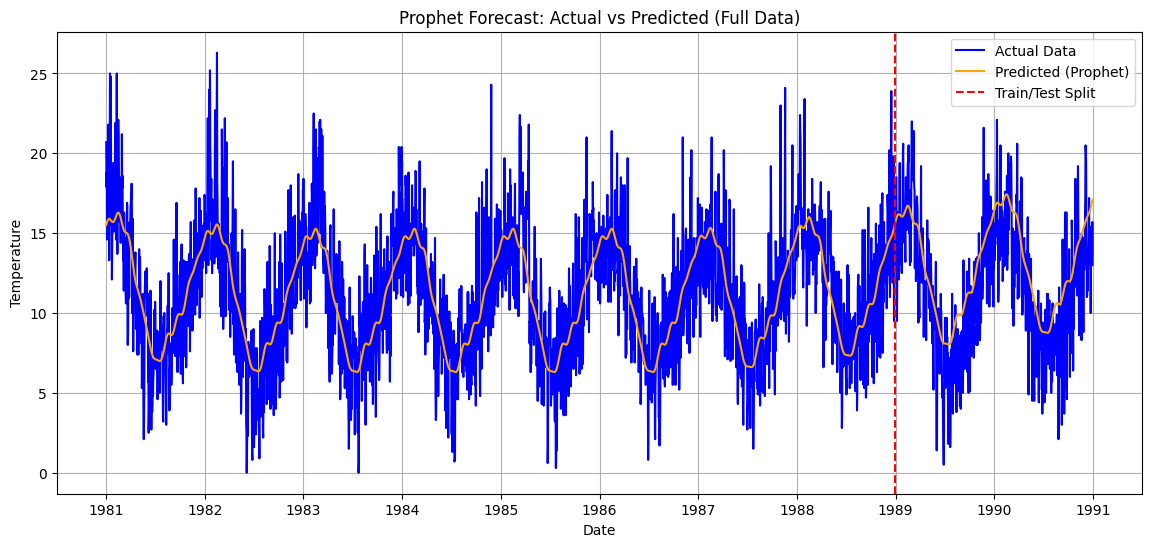

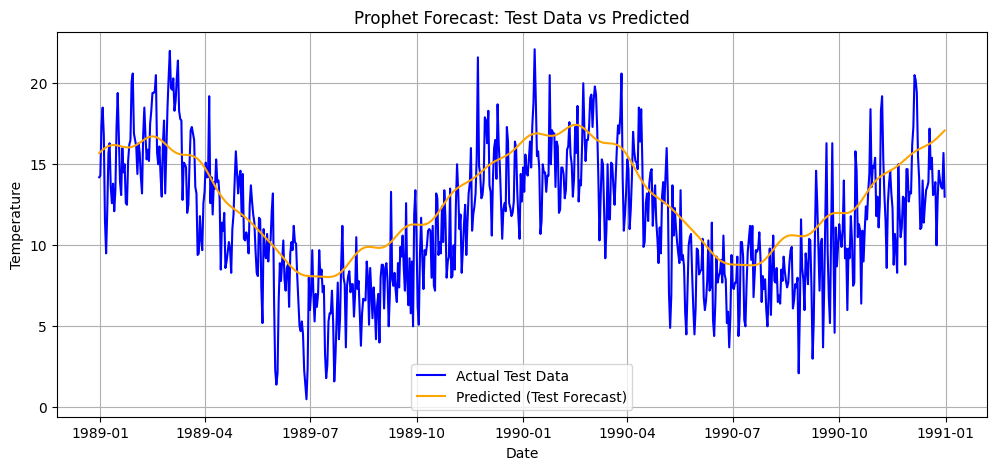

In [31]:
forecast_all = forecast[['ds', 'yhat']].set_index('ds')
data_all = data.set_index('ds')
combined = data_all.join(forecast_all, how='left')


# Plot Actual vs Predicted (Entire Dataset)
# -----------------------------
plt.figure(figsize=(14,6))
plt.plot(data_all.index, data_all['y'], label='Actual Data', color='blue')
plt.plot(forecast_all.index, forecast_all['yhat'], label='Predicted (Prophet)', color='orange')
plt.axvline(x=test_data_prophet['ds'].iloc[0], color='red', linestyle='--', label='Train/Test Split')
plt.title("Prophet Forecast: Actual vs Predicted (Full Data)")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 7️⃣ Plot Only Test Period (Zoomed-In)
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(test_data_prophet['ds'], test_data_prophet['y'], label='Actual Test Data', color='blue')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Predicted (Test Forecast)', color='orange')
plt.title("Prophet Forecast: Test Data vs Predicted")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
combined

y       yhat
ds                         
1981-01-01  20.7  15.510293
1981-01-02  17.9  15.573309
1981-01-03  18.8  15.632464
1981-01-04  14.6  15.686958
1981-01-05  15.8  15.736077
...          ...        ...
1990-12-27  14.0  16.791099
1990-12-28  13.6  16.863700
1990-12-29  13.5  16.937230
1990-12-30  15.7  17.010873
1990-12-31  13.0  17.083760

[3652 rows x 2 columns]

### **NeuralProphet**

In [37]:
import numpy as np
if not hasattr(np, 'NaN'):
    np.NaN = np.nan


In [52]:
data['ds'] = pd.to_datetime(data['ds'])

train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# 'ds' should be in datetime format

# NeuralProphet Model

np_model = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs=100,
    batch_size=64,
    learning_rate=0.01,
    seasonality_mode='additive'  # 'multiplicative' isnot giving good results - Train → RMSE: 2.884, R²: 0.494 & Test  → RMSE: 3.095, R²: 0.431
)


metrics = np_model.fit(train_data, freq='D')


# Predict next 365 days beyond available data
future = np_model.make_future_dataframe(train_data, periods=len(test_data), n_historic_predictions=True)
forecast = np_model.predict(future)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.973% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.973% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [49]:
# Evaluate performance

train_forecast = forecast.iloc[:len(train_data)]
test_forecast = forecast.iloc[len(train_data):]

train_rmse = np.sqrt(mean_squared_error(train_data['y'], train_forecast['yhat1']))
train_r2 = r2_score(train_data['y'], train_forecast['yhat1'])
test_rmse = np.sqrt(mean_squared_error(test_data['y'], test_forecast['yhat1']))
test_r2 = r2_score(test_data['y'], test_forecast['yhat1'])

print(f"Train → RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Test  → RMSE: {test_rmse:.3f}, R²: {test_r2:.3f}")



Train → RMSE: 2.884, R²: 0.494
Test  → RMSE: 3.095, R²: 0.431


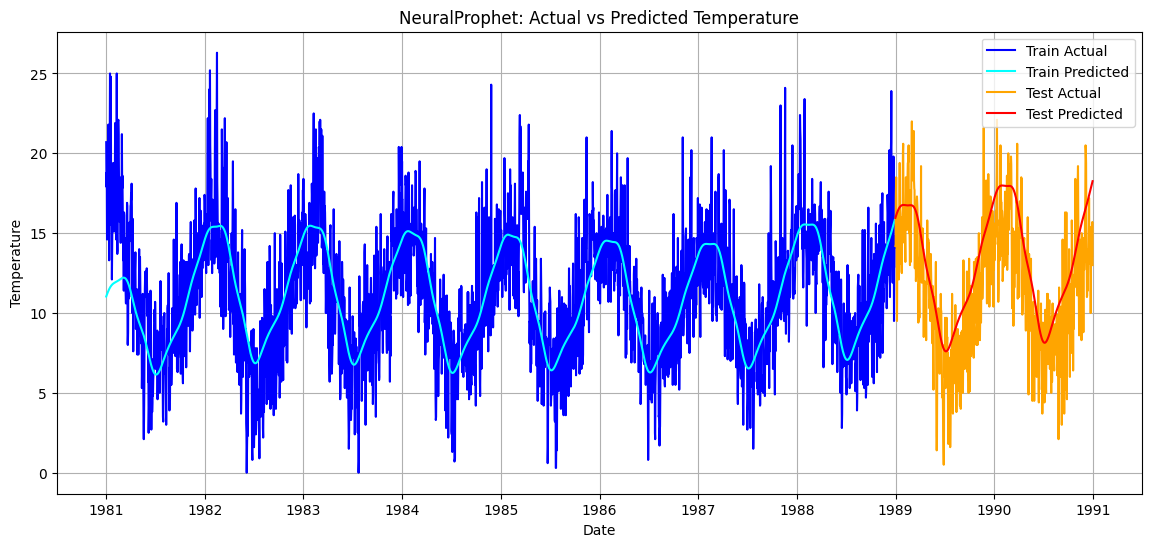

In [50]:
# Plot Actual vs Predicted

plt.figure(figsize=(14,6))
plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='blue')
plt.plot(train_data['ds'], train_forecast['yhat1'], label='Train Predicted', color='cyan')

plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='orange')
plt.plot(test_data['ds'], test_forecast['yhat1'], label='Test Predicted', color='red')

plt.title("NeuralProphet: Actual vs Predicted Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

